In [1]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

# Data Collection

US has implemented a series of non-pharmacological policies to control COVID-19 pandemic, including "shelter-in-place"/"stay-at-home", "non-essential business closure", "restuarant/ bar/ theater closure", "facemask mandates", etc. Most of the policies are state mandates, while there are cases that some counties implemented policies before its state. Since county-level policies are scarce and only include "stay-at-home" and "non-essential business closure" (see `Naco County Explorer`: https://ce.naco.org/?dset=COVID-19&ind=Emergency%20Declaration%20Types), we focus on the state-level mandates for this project.  

<p> We collect state-level policy data from the most comprehensive database gatherered by researchers in Boston University. This dataset has been widely used in literature and is continuously being validated and updated. 

Data Source: `COVID-19 US State Policy Database (CUSP)`
<br> Link: https://docs.google.com/spreadsheets/d/1zu9qEWI8PsOI_i8nI_S29HDGHlIp2lfVMsGxpQ5tvAQ/edit#gid=973655443

## Data input

In [3]:
df_policy = pd.read_excel(r"../../02_Data\03_Policy\COVID_StatePolicy_final.xlsx")
df_policy.head()

,state,state_code,state_fips,emergency,stay_at_home,gathering,end_stay_at_home,close_school,close_nonessential_business,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,Alabama,AL,1,2020-03-13,2020-04-04,0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
1,Alaska,AK,2,2020-03-11,2020-03-28,0,2020-04-24,2020-03-16,2020-03-24,2020-03-18,2020-03-18,2020-03-18,2020-03-18,2020-04-24,2020-04-24,2020-05-08,2020-05-08,2020-05-08,2020-04-24
2,Arizona,AZ,4,2020-03-11,2020-03-31,1,2020-05-16,2020-03-16,2020-03-31,2020-03-21,2020-03-21,2020-03-21,2020-03-21,2020-05-08,2020-05-11,2020-05-13,2020-05-16,2020-05-16,NaT
3,Arkansas,AR,5,2020-03-11,NaT,0,NaT,2020-03-17,2020-04-06,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-05-04,2020-05-11,2020-05-04,2020-05-18,2020-05-19,2020-07-20
4,California,CA,6,2020-03-04,2020-03-19,0,NaT,2020-03-23,2020-03-19,2020-03-16,2020-03-19,2020-03-19,2020-03-16,2020-05-08,2020-05-18,NaT,NaT,NaT,2020-06-18


In [5]:
# merge with case data to do EDA together
df_case = pd.read_csv(r"../../02_Data\01_COVID\covid_us_county.csv")
df_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')

# Data cleaning

First look at the data types.

In [6]:
df_merge.dtypes

fips                                  float64
county                                 object
state                                  object
lat                                   float64
long                                  float64
date                                   object
cases                                   int64
state_code                             object
deaths                                  int64
state_fips                            float64
emergency                      datetime64[ns]
stay_at_home                   datetime64[ns]
gathering                             float64
end_stay_at_home               datetime64[ns]
close_school                   datetime64[ns]
close_nonessential_business    datetime64[ns]
close_restaurant               datetime64[ns]
close_gym                      datetime64[ns]
close_theater                  datetime64[ns]
close_bar                      datetime64[ns]
reopen_business                datetime64[ns]
reopen_restaurant              dat

## Case data
(1) Generate daily increase;
<br>(2) Clean the observations with negative increase;
<br>(3) Calculate 7-day moving average of new cases.

In [7]:
# get daily data from cumulative sum
df_merge['new_cases']=df_merge['cases'].groupby(df_merge['fips']).diff().fillna(0)
df_merge['new_deaths']=df_merge['deaths'].groupby(df_merge['fips']).diff().fillna(0)

# impute 0 for dates with negative case inceases
df_merge['new_cases']=df_merge['new_cases'].clip(lower=0)
df_merge['new_deaths']=df_merge['new_deaths'].clip(lower=0)

# Calculate 7-day moving average
df_merge['cases_7day_ave'] = df_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

## Policy data
Code dummy variables for the key policies (i.e.,'stay_at_home','close_school','close_nonessential_business','close_restaurant','facemask','gethering','close_gym','close_theater','close_bar')

In [8]:
df_merge['policy_home']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_school']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_business']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_restaurant']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_facemask']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['facemask'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_gym']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_gym'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_gym'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_theater']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_theater'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_theater'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_bar']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_bar'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_bar'].astype('datetime64[ns]')), 1, 0)


# EDA Figures

## Cases

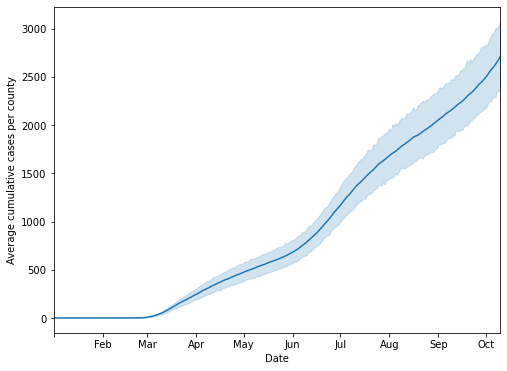

In [9]:
# cumulative cases
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%b-%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Average cumulative cases per county')
plt.show()

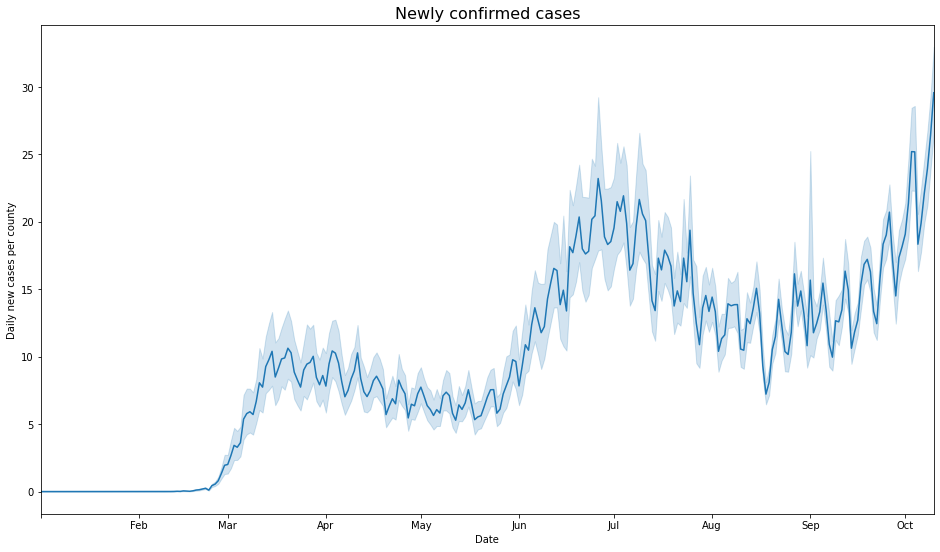

In [14]:
# new cases
plt.figure(figsize=(16,9))
g=sns.lineplot(x="date", y="new_cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.title("Newly confirmed cases",fontsize=16)
plt.show()

We see a clear weekly circular patterns in the newly confirmed cases.

In [15]:
df_merge['policy_home'][df_merge['date']=="2020-03-10"].mean()

0.0

## Policies

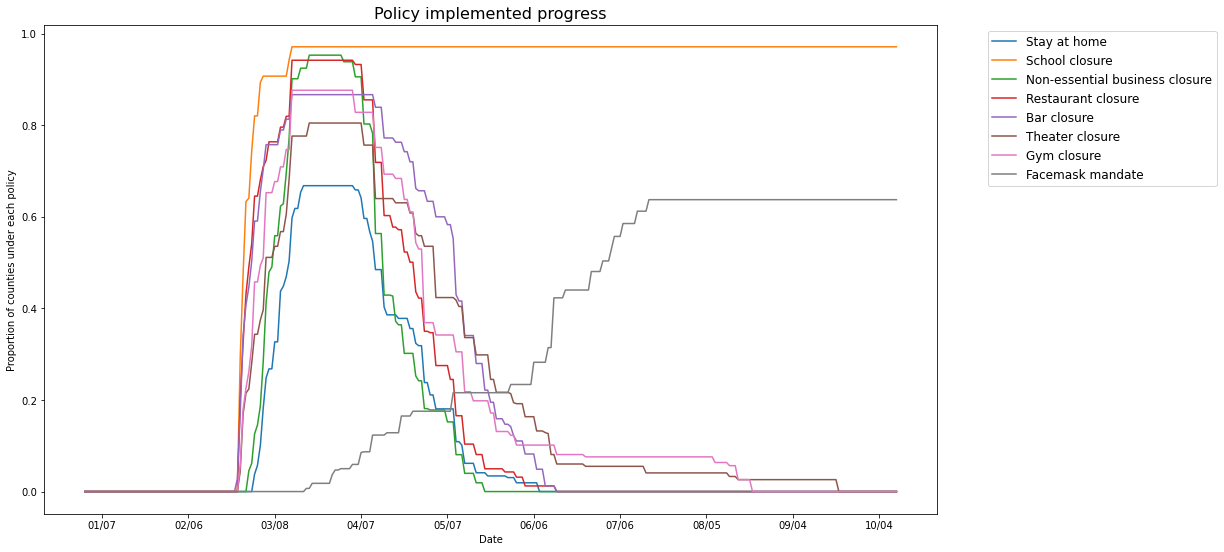

In [27]:
plt.figure(figsize=(16,9))
g=sns.lineplot(x="date", y="policy_home",ci=None,label="Stay at home",
             data=df_merge)
sns.lineplot(x="date", y="policy_school",ci=None,label="School closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_business",ci=None,label="Non-essential business closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_restaurant",ci=None,label="Restaurant closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_bar",ci=None,label="Bar closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_theater",ci=None,label="Theater closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_gym",ci=None,label="Gym closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_facemask",ci=None,label="Facemask mandate",
             data=df_merge)

g.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
g.xaxis.set_major_locator(mdates.DayLocator(interval=30))
g.set_xlabel('Date')
g.set_ylabel('Proportion of counties under each policy')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title("Policy implemented progress",fontsize=16)
plt.show()

It can be seen that there are most policies, except "facemask mandates", are implemented around the same time period (i.e., end of March and early April) and end in May.

<p> Since there are large correlations in the timing of policies, we conduct a PCA analysis to better understand the orthogality of policies.

In [17]:
X=df_merge[['policy_home','policy_school','policy_business','policy_restaurant',
              'policy_gym','policy_bar','policy_theater','policy_facemask']]
pca = PCA().fit(X)
X_pca = pca.transform(X)
print('PCA dimensions:', X_pca.shape)

var_pca1=pca.explained_variance_ratio_[0]
var_pca2=pca.explained_variance_ratio_[1]
print(f"PCA1 explains {var_pca1.round(4)} of the variance, while PCA2 explains {var_pca2.round(4)}.")

PCA dimensions: (945220, 8)
PCA1 explains 0.5463 of the variance, while PCA2 explains 0.2081.


In [18]:
pca.components_[0]

array([ 0.29351064,  0.16205592,  0.36593995,  0.4318678 ,  0.4345741 ,
        0.43959054,  0.41146298, -0.1255837 ])

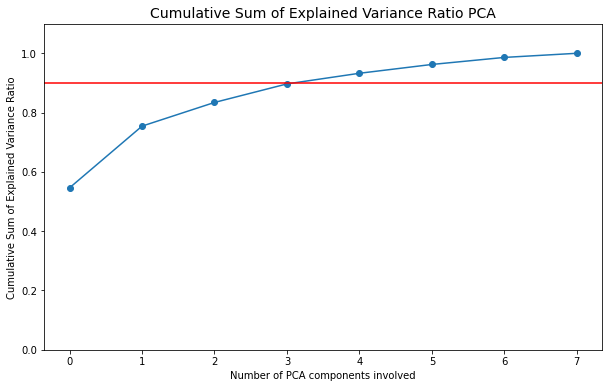

In [19]:
plt.figure(figsize=(10,6))

ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(ratio), 'o-')
plt.axhline(0.9,color='r')
plt.title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.xlabel("Number of PCA components involved")

plt.show()

In [20]:
pd.DataFrame({'Policy':list(X.columns),'PCA1':pca.components_[0],'PCA2':pca.components_[1]})

,Policy,PCA1,PCA2
0,policy_home,0.293511,-0.004000
1,policy_school,0.162056,0.601847
2,policy_business,0.365940,-0.027581
3,policy_restaurant,0.431868,-0.032506
4,policy_gym,0.434574,0.044617
5,policy_bar,0.439591,-0.028032
6,policy_theater,0.411463,0.049677
7,policy_facemask,-0.125584,0.794168


We can see that three of the policies can explain 90% of the variance. The two principal components mainly comprise of the closure policies and facemask respectively. 

## Correlations
We now explore the correlation between COVID cases and the timing for which states implemented "stay-at-home" orders. 

Which states implemented the "stay-at-home" orders earliest?

In [21]:
df_policy.sort_values(by=['stay_at_home'], ascending=True)[0:9][['state','stay_at_home']]

,state,stay_at_home
4,California,2020-03-19
30,New Jersey,2020-03-21
13,Illinois,2020-03-21
32,New York,2020-03-22
47,Washington,2020-03-23
37,Oregon,2020-03-23
18,Louisiana,2020-03-23
45,Vermont,2020-03-24
48,West Virginia,2020-03-24


We define "early adopter" as the states which implemented stay-at-home earlier (defined by median date of all the policy adopters).

In [22]:
medium_order=df_merge['stay_at_home'].astype('datetime64[ns]').quantile(.5)
df_merge['early_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')<medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['late_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')>=medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['never_adopter']=np.where(df_merge['stay_at_home'].notna()==False,1,0)

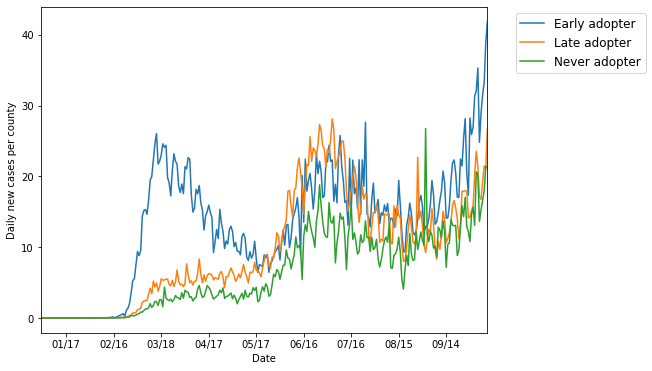

In [23]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="new_cases",ci=None,label="Early adopter",
             data=df_merge[df_merge['early_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Late adopter",
             data=df_merge[df_merge['late_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Never adopter",
             data=df_merge[df_merge['never_adopter']==1])

g.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
g.xaxis.set_major_locator(mdates.DayLocator(interval=30))
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

It can been seen that states with more severe cases are more likely to adopt stay-at-home order earlier.